# Treinando um modelo convolucional com pytorch:

In [ ]:
# Configurar GPU:

# Editar -> Configurações de notebook -> Escolhe uma opção diferente de CPU e salva!

In [ ]:
# Confirmando que estamos utilizando GPU:
!nvidia-smi

Sat Jan 13 15:13:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
#Importando bibliotecas que serão utilizadas
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [ ]:
# Setando o device para GPU se existir
if torch.cuda.is_available():
    print("GPU disponível. Usando GPU.")
    device = torch.device('cuda')
else:
    print("GPU não disponível. Usando CPU.")
    device = torch.device('cpu')

GPU disponível. Usando GPU.


In [ ]:
# Definindo a arquitetura da rede neural (Convoolução + Pooling)
class Rede_simples(nn.Module):
    def __init__(self):
        super(Rede_simples, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(p=0.3) # 30% dos pesos serão "desligados"
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Ajuste a entrada Linear conforme necessário
        nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        self.fc2 = nn.Linear(128, 10)
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Não precisa definir a camada softmax devido ao ato da função de erro precisar dos logits como entrada

In [ ]:
# Carregando o conjunto de dados MNIST (Fashion)
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Criando um DataLoader para facilitar o treinamento dividindo todo o dataset em lotes
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

100%|██████████| 26421880/26421880 [00:00<00:00, 117353280.57it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 92040804.88it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 67328200.88it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


100%|██████████| 5148/5148 [00:00<00:00, 17568980.47it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
classes_fashion = [
    'Camiseta/Topo',
    'Calça',
    'Suéter',
    'Vestido',
    'Casaco',
    'Sandalia',
    'Camisa',
    'Tênis',
    'Bolsa',
    'Bota no Tornozelo'
]

In [ ]:
# converter de tensor para imagem:
def converter_imagem(tensor):
  imagem = tensor.clone().detach().numpy() #cria uma cópia do tensor e desanexa para utilizar com numpy
  imagem = imagem.transpose(1,2,0)
  imagem = imagem.clip(0,1)
  return imagem

# Função para exibir várias imagens
def grade_imagens(train_loader, string_color, classes):
  # Iterar sobre as imagens de um lote exibindo tambem a classe
  for batch in train_loader:
      imagens, rotulos = batch
  fig = plt.figure(figsize=(6,4))
  fig.subplots_adjust(hspace=1)

  for idx in np.arange(4):
    ax = fig.add_subplot(2,2,idx+1)
    plt.imshow(converter_imagem(imagens[idx]), cmap=string_color)
    ax.set_title(f"Label: {classes[rotulos[idx].item()]}")
    ax.set_xticks([])
    ax.set_yticks([])

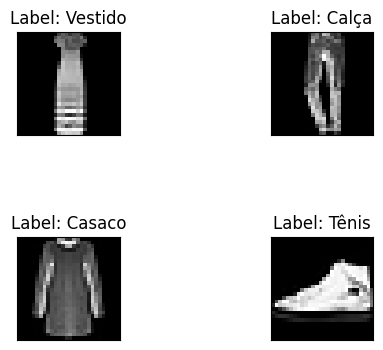

In [ ]:
grade_imagens(train_loader, "gray", classes_fashion)

In [ ]:
# Inicializando o modelo, a função de perda e o otimizador
def inicializar(modelo, lr_rate):
  criterio = nn.CrossEntropyLoss()
  otimizador = optim.Adam(modelo.parameters(), lr=lr_rate)
  return criterio, otimizador

In [ ]:
taxa_aprendizado = 0.001
modelo = Rede_simples()
criterio, otimizador = inicializar(modelo, taxa_aprendizado)

In [ ]:
# Move o modelo para a GPU, se disponível
modelo = modelo.to(device)

# Visualizando a estrutura do modelo
print(modelo)

Rede_simples(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [ ]:
def Treinamento(epocas, modelo, train_loader, criterio, otimizador, device):
  start = time.time()
  for epoch in range(epocas):
      epoch_loss = 0.0  # Inicializa/zera a loss para a época
      for data in train_loader:
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)  # Move os dados para a GPU, se disponível
          otimizador.zero_grad()
          outputs = modelo(inputs)
          loss = criterio(outputs, labels)
          loss.backward()
          otimizador.step()
          epoch_loss += loss.item()  # Acumula a loss para a época

      # Calculando a média da loss para a época
      avg_epoch_loss = epoch_loss / len(train_loader)

      # Exibindo a loss média para a época
      print(f'Época {epoch + 1}/{epocas}, Loss de treinamento média: {avg_epoch_loss:.3f}')

  end = time.time()
  print(f"Treinamento concluído em {end-start:.2f} segundos")
  return modelo

In [ ]:
# Treinamento do modelo
epocas = 5
modelo = Treinamento(epocas, modelo, train_loader, criterio, otimizador, device)

Época 1/5, Loss de treinamento média: 0.541
Época 2/5, Loss de treinamento média: 0.338
Época 3/5, Loss de treinamento média: 0.287
Época 4/5, Loss de treinamento média: 0.260
Época 5/5, Loss de treinamento média: 0.237
Treinamento concluído em 48.76 segundos


In [ ]:
# Avaliando o modelo no conjunto de teste
def Avaliacao_modelo(modelo, test_loader):
  modelo.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for data in test_loader:
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)  # Move os dados para a GPU, se disponível
          outputs = modelo(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  accuracy = correct / total
  print(f'Acurácia no teste: {accuracy * 100:.2f}%')

In [ ]:
# Avaliação do modelo criado
Avaliacao_modelo(modelo, test_loader)

Acurácia no teste: 90.99%


In [ ]:
def exibir_predicao(modelo_escolhido,dataset,string_color, classes):
  # Escolhendo uma imagem aleatória do conjunto de teste
  rand_idx = np.random.randint(len(dataset))
  image, label = dataset[rand_idx]

  # Adicionando uma dimensão para o lote
  image = image.unsqueeze(0)

  # Move a imagem para a GPU
  image = image.to(device)

  # Fazendo uma predição com o modelo_escolhido treinado
  modelo_escolhido.eval()
  with torch.no_grad():
    output = modelo_escolhido(image)  # Adiciona uma dimensão para o lote

  # Normalizando as probabilidades das classes
  softmax_output = F.softmax(output, dim=1)

  # Obtendo as probabilidades e índices das classes previstas
  probabilities, predicted_class = torch.max(softmax_output, 1)

  # Exibindo as probabilidades
  print(f"Probabilidade: {probabilities.item()*100:.2f}")

  # Exibindo a imagem e o resultado da predição
  if string_color == "gray":
    plt.imshow(image.cpu().squeeze(), cmap=string_color)
    plt.title(f'Real: {classes[label]}, Predição: {classes[predicted_class.item()]}')
    plt.show()
  else:
    image = image.cpu().squeeze().numpy().transpose((1, 2, 0))  # Convertendo para o formato (224, 224, 3)
    plt.imshow(image, cmap=string_color)
    plt.title(f'Real: {classes[label]}, Predição: {classes[predicted_class.item()]}')
    plt.show()

Probabilidade: 66.58


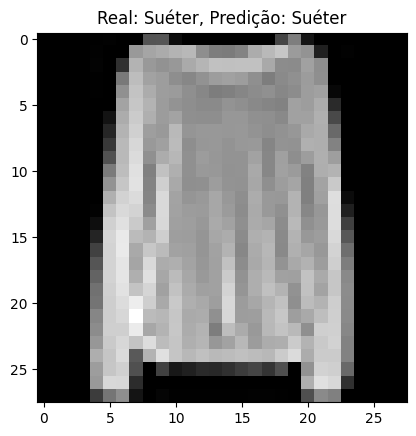

In [ ]:
# Realiza predição e exibe
string_color = "gray"
exibir_predicao(modelo,test_dataset, string_color, classes_fashion)

In [ ]:
def salvar_modelo(nome_modelo):
  # Especificando o caminho do diretório que você deseja criar
  caminho_diretorio = './modelos'

  # Verificar se o diretório não existe antes de criar
  if not os.path.exists(caminho_diretorio):
      os.makedirs(caminho_diretorio)
      print(f'Diretório {caminho_diretorio} criado com sucesso!')
  else:
      print(f'O diretório {caminho_diretorio} já existe.')

  # Especificando o caminho do arquivo onde você deseja salvar o modelo
  caminho_arquivo = './modelos/'+str(nome_modelo)+'.pth'

  # Salvar o modelo
  torch.save(modelo.state_dict(), caminho_arquivo)

In [ ]:
# Salvando o modelo treinado
nome_modelo = 'classificador_roupas'
salvar_modelo(nome_modelo)

Diretório ./modelos criado com sucesso!


In [ ]:
#Baixando o arquivo .pth para a máquina local
from google.colab import files
#files.download('./modelos/modelo_treinado.pth')

In [ ]:
def carrega_modelo(nome_modelo):
  caminho_arquivo = './modelos/'+str(nome_modelo)+'.pth'
  modelo_carregado = torch.load(caminho_arquivo)

In [ ]:
# Carregando o modelo
nome_modelo = 'classificador_roupas'
carrega_modelo(nome_modelo)

# Transferência de aprendizado:

Consiste basicamente em congelar as camadas de extração de features, mudar o numero de nós de saída para o número de classes do dataset atual e treinar utilizando os novos dados.

In [ ]:
#Clonando um dataset rotulado sobre abelhas e formigas
!git clone https://github.com/jaddoescad/ants_and_bees.git

Cloning into 'ants_and_bees'...
remote: Enumerating objects: 408, done.
remote: Total 408 (delta 0), reused 0 (delta 0), pack-reused 408
Receiving objects: 100% (408/408), 45.03 MiB | 4.19 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [ ]:
transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

training_dataset = datasets.ImageFolder('ants_and_bees/train', transform=transform)
validation_dataset = datasets.ImageFolder('ants_and_bees/val', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 1000, shuffle=False)

In [ ]:
print(len(training_dataset), len(validation_dataset))

244 153


In [ ]:
classes_insetos = ['formiga', 'abelha']

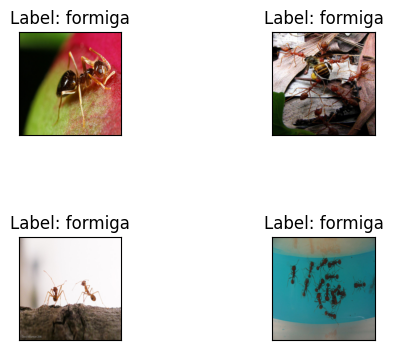

In [ ]:
grade_imagens(training_loader, None, classes_insetos)

In [ ]:
# Carregando um modelo pronto
modelo_pronto = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 120MB/s]


In [ ]:
print(modelo_pronto)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# Congelando a atualização de gradiente nas camadas de extração de features
for parametro in modelo_pronto.features.parameters():
  parametro.requires_grad = False

In [ ]:
# Atualizando o número de nós da camada de saída do nosso modelo pronto
n_entrada = modelo_pronto.classifier[6].in_features
nova_camada_final = nn.Linear(n_entrada, len(classes_insetos))
modelo_pronto.classifier[6] = nova_camada_final
modelo_pronto.to(device)
print(f"Novo númro de nós de saída: {modelo_pronto.classifier[6].out_features}")

Novo númro de nós de saída: 2


In [ ]:
taxa_aprendizado = 0.0001
criterio, otimizador = inicializar(modelo_pronto, taxa_aprendizado)

In [ ]:
num_epocas = 8
modelo_pronto = Treinamento(num_epocas, modelo_pronto, training_loader, criterio, otimizador, device)

Época 1/8, Loss de treinamento média: 0.528
Época 2/8, Loss de treinamento média: 0.217
Época 3/8, Loss de treinamento média: 0.146
Época 4/8, Loss de treinamento média: 0.061
Época 5/8, Loss de treinamento média: 0.035
Época 6/8, Loss de treinamento média: 0.028
Época 7/8, Loss de treinamento média: 0.013
Época 8/8, Loss de treinamento média: 0.014
Treinamento concluído em 13.44 segundos


In [ ]:
Avaliacao_modelo(modelo_pronto, validation_loader)

Acurácia no teste: 84.31%


Probabilidade: 99.50


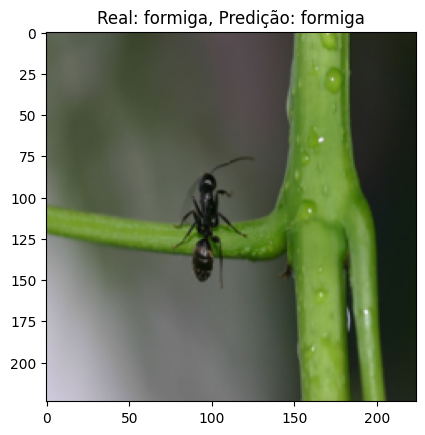

In [ ]:
# Realiza predição e exibe
string_color = None
exibir_predicao(modelo_pronto,validation_dataset, string_color, classes_insetos)